# 1. Goal of the Project
The prevalence of fake news leads to the spread of misinformation and can cause unnecessary conflict.  The goal of this project is to evaluate articles and classify them as either real or fake news.  This will be an deep learning model to attempt to classify the articles.  The approach will be to clean the data and perform some exploratory data analysis to get a high-level understanding of the dataset.  I will then leverage deep learning models to create a classification model to predict if an article is real or fake news.  I will create a models using the simple recurrent neural network (RNN), gated recurrent units (GRU), bidirectional GRU, and NeuralNetBinaryClassifer (from the skorch library) architectures.

This project has been published to GitHub at https://github.com/cmis1/MSDS/tree/main/DTSA%205511/Final.  

In [109]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import re
import seaborn as sns
import string
import time
import tensorflow as tf
import torch
import torch.nn as nn
import keras_tuner

from keras.callbacks import EarlyStopping
from skorch import NeuralNetBinaryClassifier
from tensorflow.keras import Input, layers, models, optimizers, losses

from collections import Counter
from nltk.stem import WordNetLemmatizer as wnl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# 2. Data Understanding
Curated by the Information Security and Object Technology (ISOT) research lab at the University of Victoria, the dataset contains 23k fake news articles and 21k real news articles. The real news articles were collected from Reuters.com, while the fake news articles were collected from websites flagged by Politifact and Wikipedia. The articles cover a variety of topics, but a majority focus on political and world news topics.    

## 2.1 Data Citation in APA Format
The original dataset authors are from the ISOT research lab at the University of Victoria.
1. Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text
classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley,
January/February 2018.
2. Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram
Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds)
Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments.
ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-
138).

The data is available on Kaggle at:
1. Kodi, Malar. (2021). ISOT Fake News Dataset. Version 1. [Data set]. Retrieved from https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset.


## 2.2 Data Description
As mentioned above, there are 23k fake news articles and 21k true news articles contained in two CSV files: Fake.csv and True.csv.  The columns in the CSV are:

| Column | Data Type | Description |
| --- | --- | --- |
| Title | object (string) | title of news article |
| Text | object (string) |body text of news article |
| Subject | object (string) |subject of news article |
| Date | object (date) |publish date of news article |

## 2.3 Load the Data
I load the True and Fake CSV files and verify the data types and number of rows are as described above.

In [2]:
df_true = pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
df_fake= pd.read_csv('Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
BOLD = '\033[1m'
END = '\033[0m'

print(BOLD + 'True dataset:' + END)
df_true.info()

print(BOLD + '\nFake dataset:' + END)
df_fake.info()

True dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB

Fake dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


# 3. Data Cleaning and Exploratory Data Analysis

## 3.1 Combine Datasets
First, I need to add a label of 1 to each true article and 0 to each fake article.  Then, I combine the real and fake news articles together and shuffle the data set.

In [5]:
df_true['label'] = 1
df_fake['label'] = 0

In [6]:
df_articles = pd.concat([df_true, df_fake])
df_articles = df_articles.sample(frac=1, random_state=42).reset_index(drop=True)
df_articles.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


## 3.2 Data Types and Columns
For this model, I will focus on using an article's text to predict its label (i.e., real or fake news).  Therefore, I will remove the other columns.

In [46]:
df_articles = df_articles[['text', 'label']]
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43390 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43390 non-null  object
 1   label   43390 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1017.0+ KB


## 3.3 Article Length
There are some articles that do not contain text (i.e., length = 0) and other articles that are significantly longer than the rest.  

In [8]:
df_articles['length'] = df_articles[['text', 'label']].text.apply(lambda x: len(x.split()))
df_articles[['label', 'length']].groupby('label').describe()

length                                                          
         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      23481.0  423.197905  408.388890  0.0  240.0  363.0  506.0  8135.0
1      21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0

<Axes: xlabel='length'>

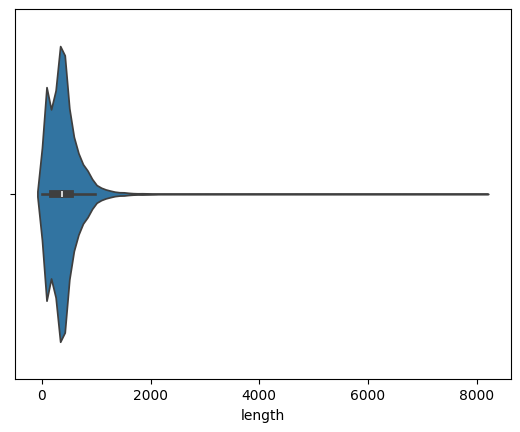

In [9]:
sns.violinplot(data=df_articles, x='length')

### 3.3.1 Empty articles
I filtered out the 631 articles without text.

In [10]:
len(df_articles[df_articles['length'] == 0])

631

In [11]:
df_articles = df_articles[df_articles['length'] > 0]
df_articles[['label', 'length']].groupby('label').describe()

length                                                            
         count        mean         std   min     25%    50%    75%     max
label                                                                     
0      22851.0  434.865433  407.806095   1.0  254.00  369.0  511.0  8135.0
1      21416.0  385.658106  273.999928  22.0  148.75  359.0  525.0  5172.0

### 3.3.2 Minimum length
The minimum word length of fake articles is 1, which still isn't much of an article.  There are 591 articles with word lengths less than the 22-word minimum length of a real article.  I will filter out articles less than 22 words to create a more balanced data set in terms of article length between real and fake news.

In [12]:
len(df_articles[df_articles['length'] < 22])

591

In [13]:
df_articles = df_articles[df_articles['length'] > 21]
df_articles[['label', 'length']].groupby('label').describe()

length                                                            
         count        mean         std   min     25%    50%    75%     max
label                                                                     
0      22260.0  446.105660  407.228220  22.0  267.00  375.0  516.0  8135.0
1      21416.0  385.658106  273.999928  22.0  148.75  359.0  525.0  5172.0

### 3.3.3 Outliers
To deal with the extreme outliers, I will filter out articles with lengths greater than 3 standard deviations away from the mean.

In [14]:
total = len(df_articles['length'])
z_scores = np.abs((df_articles['length'] - df_articles['length'].mean()) / df_articles['length'].std())

for i in range(3,7):
    count = len(df_articles['length'][z_scores >  i])
    print(f"Outliers outside {i} standard deviations: {count} ({count*100/total:.2f}% of dataset)")

Outliers outside 3 standard deviations: 487 (1.12% of dataset)
Outliers outside 4 standard deviations: 286 (0.65% of dataset)
Outliers outside 5 standard deviations: 188 (0.43% of dataset)
Outliers outside 6 standard deviations: 157 (0.36% of dataset)


In [15]:
df_articles = df_articles[z_scores < 4]
df_articles['length'].describe()

count    43390.000000
mean       399.397119
std        259.568981
min         22.000000
25%        219.000000
50%        367.000000
75%        515.000000
max       1813.000000
Name: length, dtype: float64

### 3.3.4 Article Length Conclusion
Real articles have a tendency to be shorter than fake articles, but I do not have as heavy as a right skew as I did previously.  After cleaning the data set for article length, I still have a fairly balanced dataset in terms of the number of real (21,399) vs fake (21,991) articles.

<Axes: xlabel='length'>

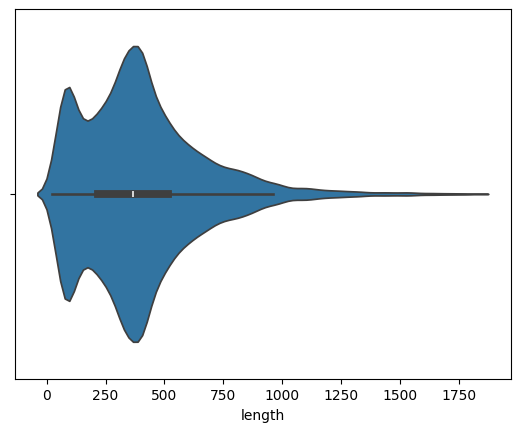

In [16]:
sns.violinplot(data=df_articles, x='length')

In [17]:
df_articles[['label', 'length']].groupby('label').describe()

length                                                           
         count        mean         std   min    25%    50%    75%     max
label                                                                    
0      21991.0  414.505207  252.745320  22.0  265.0  372.0  509.0  1813.0
1      21399.0  383.871069  265.511075  22.0  148.0  359.0  524.0  1779.0

Text(0, 0.5, 'Articles')

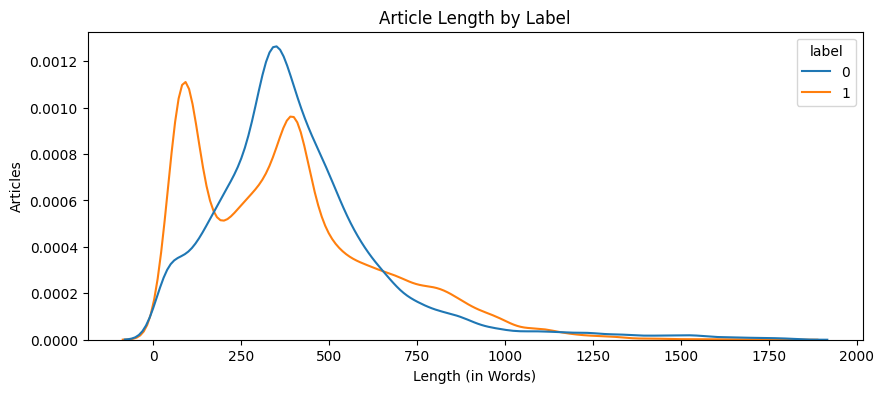

In [18]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data = df_articles, x='length', hue='label')
plt.title('Article Length by Label')
plt.xlabel('Length (in Words)')
plt.ylabel('Articles')

## 3.4 Distribution of Data
As mentioned above, I have a acceptably balanced dataset between fake and real news articles.

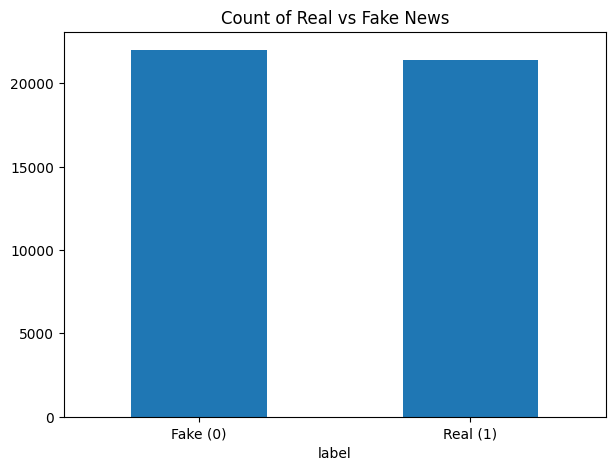

In [19]:
plt.figure(figsize=(7, 5))
ax = df_articles['label'].value_counts().plot(kind='bar', title='Count of Real vs Fake News')
plt.xticks([0, 1], rotation=0, labels=['Fake (0)', 'Real (1)'])
plt.show()

## 3.5 Word Frequency
Many of the top 20 words are "stop" words, so I will re-inspect the texts after removing the stop words during the preprocessing phase.

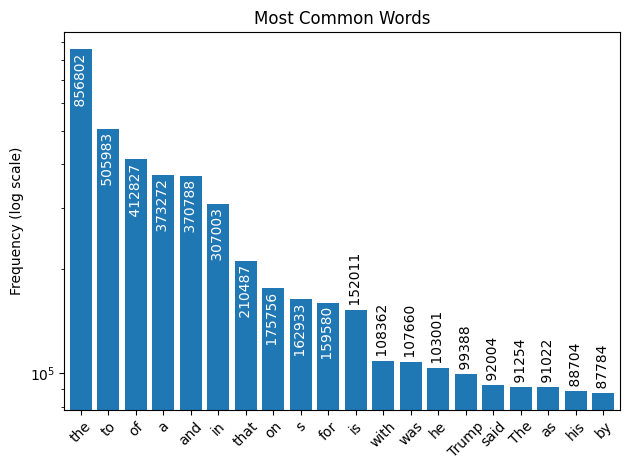

In [20]:
all_text = df_articles['text'].str.cat(sep=' ')
all_words = all_text.split()
word_counts = Counter(all_words).most_common(20)


y = [count for tag, count in word_counts]
x = [tag for tag, count in word_counts]

plt.bar(x, y)
plt.title('Most Common Words')
plt.ylabel('Frequency (log scale)')
plt.yscale('log') 
plt.xticks(rotation=45)
for i, (tag, count) in enumerate(word_counts):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout() 
plt.show()

#  4. Data Preprocessing
The article text will be cleaned by:
* changing to lower case
* removing URLs
* removing numbers
* removing mentions
* removing HTML encoded strings
* removing special characters
* tokenizing
* removing stop words
* removing punctuation
* lemmatizing

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)   #remove URLs 
    text = re.sub(r'\d+', '', text)       #remove numbers
    text = re.sub(r'@\w+', '', text)      #remove mentions
    text = re.sub(r'&\w+;', '', text)     #remove HTML encoded strings, e.g., &amp;
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)      # remove punctuation/special chars
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]
    lemmatized_tokens = [wnl().lemmatize(word) for word in filtered_tokens]
    return ' '.join(lemmatized_tokens)

In [22]:
df_articles['text'] = df_articles['text'].apply(clean_text)
df_articles.head()

,title,text,subject,date,label,length
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,donald trump white house chaos trying cover ru...,News,"July 21, 2017",0,361
1,Failed GOP Candidates Remembered In Hilarious...,donald trump presumptive gop nominee time reme...,News,"May 7, 2016",0,495
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,mike penny huge homophobe support exgay conver...,News,"December 3, 2016",0,379
3,California AG pledges to defend birth control ...,san francisco reuters california attorney gene...,politicsNews,"October 6, 2017",1,88
4,AZ RANCHERS Living On US-Mexico Border Destroy...,twisted reasoning come pelosi day especially p...,politics,"Apr 25, 2017",0,138


## 4.1 Word Frequencies
I used both a histogram and a word cloud to understand the most frequent words across three slices:  all articles, real articles, and fake articles.  Now that the stop words have been removed, the most common words are more meaningful.  It is evident that many of the articles relate to political topics across all three slices.  However, there are not many obvious differences in the most frequent words between real and fake articles.

In [117]:
def word_freq(df):
    all_text = df['text'].str.cat(sep=' ')
    all_words = all_text.split()
    word_counts = Counter(all_words)
    
    y = [count for tag, count in word_counts.most_common(20)]
    x = [tag for tag, count in word_counts.most_common(20)]

    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.title('Most Common Words')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log') 
    plt.xticks(rotation=45)
    for i, (tag, count) in enumerate(word_counts.most_common(20)):
        plt.text(i, count, f' {count} ', rotation=90,
                 ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Article Text')
    plt.show()

### 4.1.1 All Articles

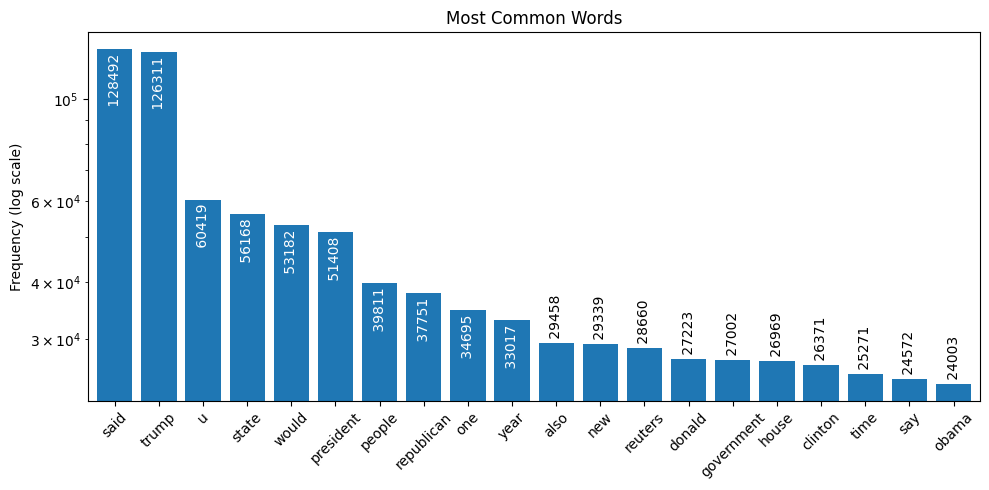

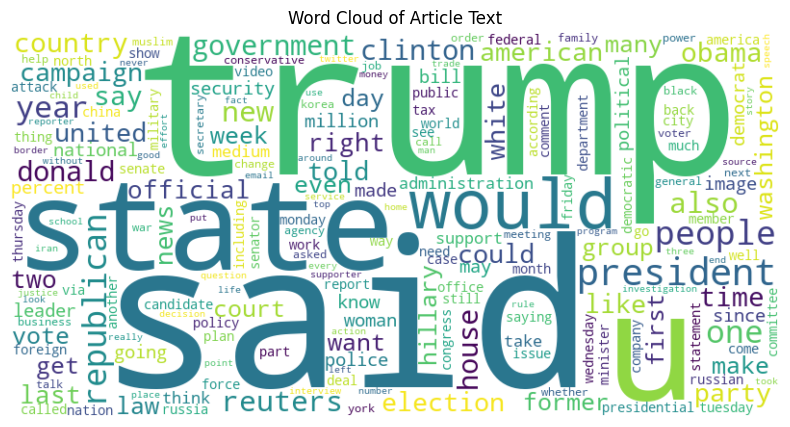

In [118]:
word_freq(df_articles)

### 4.1.2 Real Articles

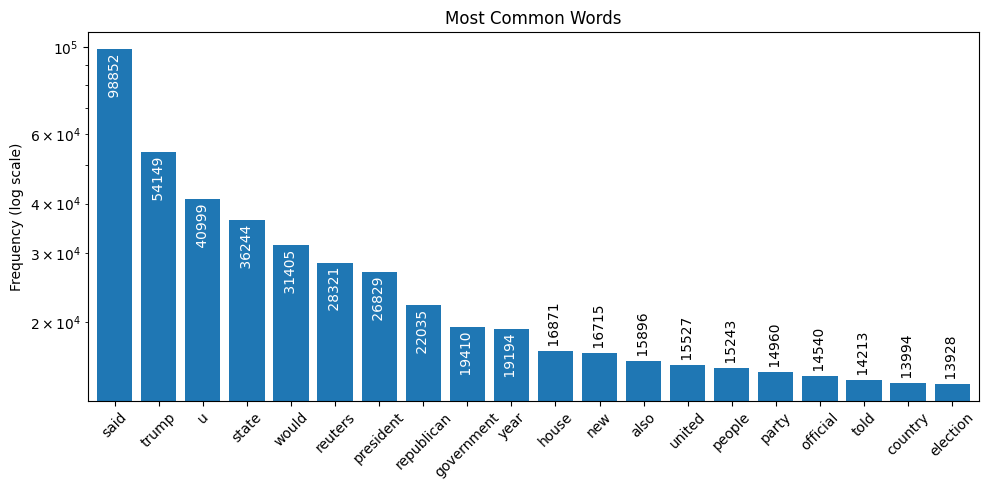

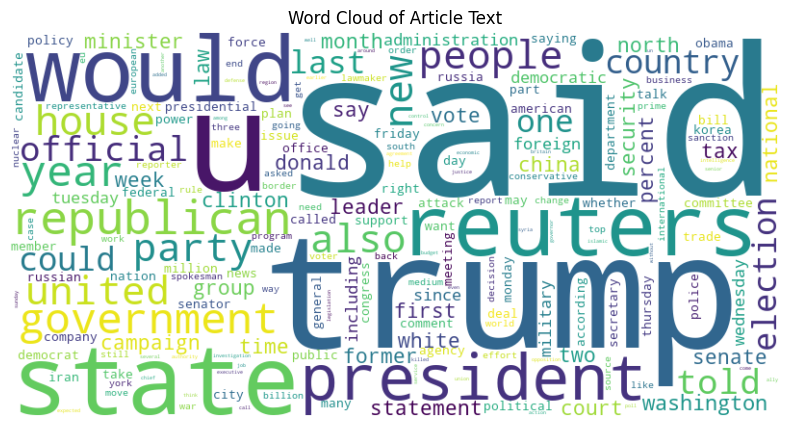

In [119]:
word_freq(df_articles[df_articles['label'] == 1])

### 4.1.3 Fake Articles

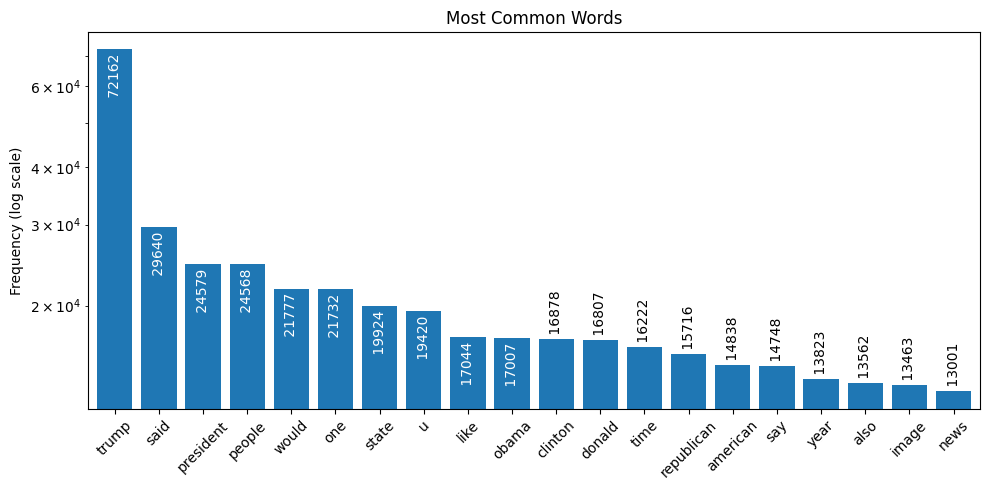

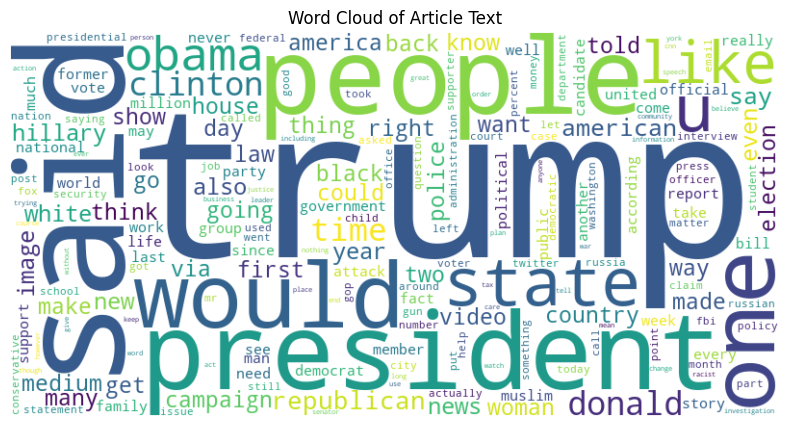

In [120]:
word_freq(df_articles[df_articles['label'] == 0])

## 4.2 Encoder Text Preprocessing
Processing and modeling the text requires a few steps that all occur within the TextVectorization layer.  

1. The data is tokenized (i.e., sentences are broken down into units/words).
2. The collection of all tokens is compiled into a vocabulary.
3. Each token is encoded to a unique integer value.
4. Text is mapped to a sequence of integer values using the encoding from the prior step.
5. The text is padded with trailing zeroes to create a rectangular matrix of encoded integers to feed into the machine learning model.

Note that the vocabulary includes an "[UNK]" value to represent any unknown tokens found in text that do not exist in the vocabulary.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df_articles['text'], df_articles['label'], stratify=df_articles['label'], test_size=0.2)

In [26]:
model_results = {}
batch_size = 64

## 4.3 Training Vocabulary and vocab size
The starting vocabulary created from the articles in the dataset contains over 166k words, but I used some trial and error to determine a vocabulary size that balanced model performance with prediction power.  I opted for using 50% of the original vocabulary present in the articles as the vocabulary size for the models.

In [28]:
encoder = layers.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
full_vocab = len(encoder.get_vocabulary())
print(f'Vocabulary contains: {full_vocab} words')

2025-07-08 19:50:01.292607: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary contains: 166389 words


In [29]:
VOCAB_SIZE = int(full_vocab * .5)
print(VOCAB_SIZE)
encoder = layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

83194


In [30]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'said', 'trump', 'u', 'state', 'would', 'president',
       'people', 'republican', 'one', 'year', 'also', 'new', 'reuters',
       'donald', 'house', 'government', 'clinton', 'time'], dtype='<U909')

### 4.3.1 Encoding and Padding
As mentioned above, the TextVectorization layer encodes each token into a unique integer value and pads article text with trailing zeroes to create rectangular matrices.  Below are some article text examples before and after encoding.

In [47]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:2])
  print()
  print('labels: ', label.numpy()[:2])

texts:  [b'washington reuters u president donald trump predicted sunday senator jeff flake oppose republican tax bill senator office say yet made mind senator flake still reviewing tax reform bill merit vote nothing president spokesman senator said email contrary assertion made trump sunday post twitter hell tax cut political career anyway toast trump wrote flake twitter individual republican senator stand tax bill become focus trying determine whether pas republican control seat senate two republican defection would likely kill bill wisconsin senator ron johnson already publicly stated opposes bill current form house voted last week approve tax bill support democrat republican defecting trump flake republican critical recent month flake delivered speech senate floor october said trump threatened nation democracy speech flake announced would seeking reelection senate next year term expires trump turn critical flake saying would able win reelection saturday event arizona flake overheard

2025-07-09 19:13:24.139080: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [48]:
encoder(example)[:2].numpy()

array([[40, 14,  4, ...,  0,  0,  0],
       [40, 14, 29, ...,  0,  0,  0]])

# 5. Modeling

## 5.1 Early Stopping
I implemented early stopping to avoid unnecessary training time with the models.

In [32]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,       # Number of epochs to wait for improvement
    min_delta=0.001,    # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'        # Direction of the metric (e.g., 'min' for loss, 'max' for accuracy)
)

## 5.2 Simple Recurrent Neural Network (RNN)
I started with a simple RNN to see if a low-complexity model would perform well.

In [33]:
simple_rnn = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.SimpleRNN(32),
    layers.Dense(1) 
])

simple_rnn.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

simple_rnn_history = simple_rnn.fit(x_train.values, 
                                    y_train.values,
                                    epochs=20,
                                    validation_data=(x_test.values, y_test.values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'Simple RNN', 
    elapsed_time,
    len(simple_rnn_history.epoch),
    max(simple_rnn_history.history['val_accuracy'])
)


Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.5046 - loss: 0.8217 - val_accuracy: 0.4961 - val_loss: 0.6912
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5155 - loss: 0.6879 - val_accuracy: 0.5154 - val_loss: 0.6864
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5153 - loss: 0.6830 - val_accuracy: 0.5007 - val_loss: 0.6832
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5246 - loss: 0.6790 - val_accuracy: 0.5207 - val_loss: 0.6810
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5191 - loss: 0.6767 - val_accuracy: 0.5209 - val_loss: 0.6849
Epoch 6/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5230 - loss: 0.6757 - val_accuracy: 0.5232 - val_loss: 0.6808
Epoch 7/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5188 - loss: 0.6744 - val_accuracy: 0.5228 - val_loss: 0.6805
Epoch 8/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.5152 -

In [34]:
model_results

{0: ('Simple RNN', 399.26129603385925, 9, 0.5231620073318481)}

### 5.2.1 Commentary
The Simple RNN did not perform overly well with a validation accuracy of 0.523.  This is not much better than flipping a coin to make the prediction.  I will need to build some complexity into the model to improve its predictive power.

## 5.3 Gated Recurrent Units (GRU)
RNNs can have difficulty with long-term relationships/dependencies in the dataset because the hidden state is being continually rewritten. GRUs add some complexity onto the simple RNN. Specifically, RNNs use reset and update gates to control the flow of information through the neural network. Gates learn which inputs are important and store information in the memory unit to handle information in long sequences.  In article text, understanding the context within long sequences is crucial. 

In [35]:
rnn_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.GRU(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) 
])

rnn_gru.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

rnn_gru_history = rnn_gru.fit(x_train.values, 
                                    y_train.values,
                                    epochs=20,
                                    validation_data=(x_test.values, y_test.values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'GRU RNN', 
    elapsed_time,
    len(rnn_gru_history.epoch),
    max(rnn_gru_history.history['val_accuracy'])
)

Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 130s 119ms/step - accuracy: 0.4998 - loss: 0.8303 - val_accuracy: 0.5068 - val_loss: 0.6964
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 130s 120ms/step - accuracy: 0.5028 - loss: 0.6946 - val_accuracy: 0.5218 - val_loss: 0.6865
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 121ms/step - accuracy: 0.5156 - loss: 0.6840 - val_accuracy: 0.5048 - val_loss: 0.6830
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 121ms/step - accuracy: 0.5140 - loss: 0.6789 - val_accuracy: 0.5229 - val_loss: 0.6771
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 121ms/step - accuracy: 0.5157 - loss: 0.6763 - val_accuracy: 0.5065 - val_loss: 0.6779
Epoch 6/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 120ms/step - accuracy: 0.5198 - loss: 0.6743 - val_accuracy: 0.5255 - val_loss: 0.6744
Epoch 7/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 120ms/step - accuracy: 0.6279 - loss: 3.2984 - val_accuracy: 0.7884 - val_loss: 1.0653
Epoch 8/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 131s 120ms/step - ac

In [36]:
model_results

{0: ('Simple RNN', 399.26129603385925, 9, 0.5231620073318481),
 1: ('GRU RNN', 1436.4854807853699, 11, 0.7884305119514465)}

### 5.3.1 Commentary
The GRU improved accuracy over the simple RNN from 0.523 to 0.788, which is a nice improvement.  However, the training time more than tripled when compared to the simple RNN.

## 5.4 Bidirectional GRU
Given the length of the articles, it may be worthwhile to change the GRU layers to be bidirectional.  A bidirectional RNN processes data both forward and backward (i.e., using past and future context) to make predictions.

In [37]:
rnn_gru_bidirectional = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) 
])

rnn_gru_bidirectional.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

rnn_gru_bidirectional_history = rnn_gru_bidirectional.fit(x_train.values, 
                                    y_train.values,
                                    epochs=20,
                                    validation_data=(x_test.values, y_test.values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'GRU RNN - Bidirectional', 
    elapsed_time,
    len(rnn_gru_bidirectional_history.epoch),
    max(rnn_gru_bidirectional_history.history['val_accuracy'])
)

Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 212s 195ms/step - accuracy: 0.6154 - loss: 1.6174 - val_accuracy: 0.9931 - val_loss: 0.0374
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 217s 200ms/step - accuracy: 0.9960 - loss: 0.0232 - val_accuracy: 0.9984 - val_loss: 0.0135
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 217s 200ms/step - accuracy: 0.9992 - loss: 0.0075 - val_accuracy: 0.9991 - val_loss: 0.0075
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 219s 202ms/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0065
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 218s 201ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9991 - val_loss: 0.0097
Epoch 6/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 218s 201ms/step - accuracy: 0.9996 - loss: 0.0067 - val_accuracy: 0.9991 - val_loss: 0.0095
Epoch 7/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 220s 203ms/step - accuracy: 0.9998 - loss: 0.0032 - val_accuracy: 0.9991 - val_loss: 0.0095
Epoch 8/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 218s 201ms/step - ac

In [38]:
model_results

{0: ('Simple RNN', 399.26129603385925, 9, 0.5231620073318481),
 1: ('GRU RNN', 1436.4854807853699, 11, 0.7884305119514465),
 2: ('GRU RNN - Bidirectional', 1739.7027468681335, 8, 0.9991933703422546)}

### 5.4.1 Commentary
The validation accuracy achieved with the bidirectional GRU is impressive at 0.999.  The training time increase a bit compared to the prior GRU model.  However, the improved accuracy makes the additional training time a worthwhile investment.

## 5.5 Skorch NeuralNetBinaryClassifier
Lastly, I tried a NeuralNetBinaryClassifier model from the skorch library.  I encoded the article text to integers prior to fitting the model rather than using the encoding layer directly in the model, as I did above.

In [39]:
X = torch.tensor(encoder(df_articles['text'].values).numpy(), dtype = torch.float32)
y = torch.tensor(df_articles['label'].values, dtype = torch.float32)

In [40]:
x_tr, x_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2)

In [41]:
#Create a custom class that build on top of the Module base class
class NewsClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1093, 60)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(60, 1)
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.output(x)
        return x

#Construct the model using the custom class above
nnbc_model = NeuralNetBinaryClassifier(
    NewsClassifier,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    max_epochs=20,
    batch_size=batch_size
)

start_time = time.time()

nnbc_history = nnbc_model.fit(x_tr, y_tr)

end_time = time.time()

elapsed_time = end_time - start_time

#Grabbing the validation accuracy out of this model was not as nice as the prior models
val_acc = []
for i in range(20):
    acc = nnbc_history.history[i]['valid_acc']
    val_acc.append(acc)


model_results[len(model_results)] = (
    'NeuralNet Binary Classifier', 
    elapsed_time,
    20,
    max(val_acc)
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1      105.3849       0.5640       65.6975  0.2724
      2       44.7032       0.5773       42.3531  0.2589
      3       25.4842       0.5912       28.1800  0.2577
      4       15.1957       0.5996       18.8144  0.2560
      5        9.2150       0.6080       12.9484  0.2558
      6        5.6644       0.6104        8.9013  0.2573
      7        3.4931       0.6100        5.9874  0.2526
      8        2.1304       0.6101        4.0548  0.2591
      9        1.3491       0.6107        2.9145  0.2625
     10        0.9401       0.6111        2.3053  0.2549
     11        0.7559       0.6167        2.0868  0.2576
     12        0.6572       0.6251        1.9229  0.2619
     13        0.5911       0.6267        1.8566  0.2596
     14        0.5519       0.6285        1.8079  0.2561
     15        0.5224       0.6310        1.7914  0.2606
     16        0.4966       0.6

In [42]:
model_results

{0: ('Simple RNN', 399.26129603385925, 9, 0.5231620073318481),
 1: ('GRU RNN', 1436.4854807853699, 11, 0.7884305119514465),
 2: ('GRU RNN - Bidirectional', 1739.7027468681335, 8, 0.9991933703422546),
 3: ('NeuralNet Binary Classifier', 5.810030937194824, 20, 0.6504392913726055)}

### 5.5.1 Commentary
The validation accuracy was not great with this model, but the training time was significantly better than the prior models.  If I could combine the training performance of this model with the validation accuracy of the bidirectional GRU, that would create a great model.

## TODO 5.6 Hyperparameter Tuning

# 6. Results and Analysis
The bidirectional GRU model had the best validation accuracy at 0.999, but it had the longest training time.  The NeuralNet Binary Classifier had a validation accuracy slightly better than chance at 0.650.  However, the NeuralNet Binary Classifier had an extremely fast training time.  This leads me to believe I did something really wrong or really right to get it to train that quickly.


In [107]:
df = pd.DataFrame.from_dict(model_results, orient='index')
df.columns = ['Model', 'Training Time', 'Epochs', 'Max Validation Accuracy']

In [108]:
df_acc = df[['Model', 'Training Time', 'Max Validation Accuracy']]
df_acc.head()

,Model,Training Time,Max Validation Accuracy
0,Simple RNN,399.261296,0.523162
1,GRU RNN,1436.485481,0.788431
2,GRU RNN - Bidirectional,1739.702747,0.999193
3,NeuralNet Binary Classifier,5.810031,0.650439
4,NeuralNet Binary Classifier - 50 epochs,12.444214,0.693648


## 6.1 Epochs
As mentioned above, I used an early stopping callback for the first three models.  This helped to keep the training time down compared to what it would have been for 20 epochs.  Given that the first three models stopped around 10 epochs, the training time could have easily doubled without the early stopping.

In [105]:
df_epoch = df[['Model', 'Training Time', 'Epochs']]
df_epoch.head()

,Model,Training Time,Epochs
0,Simple RNN,399.261296,9
1,GRU RNN,1436.485481,11
2,GRU RNN - Bidirectional,1739.702747,8
3,NeuralNet Binary Classifier,5.810031,20


## 6.2 Convergence
The validation in the simple RNN seems rather hectic.  Although the model achieves the maximum validation accuracy after five epochs, the model doesn't converge nicely.  In contrast, the bidirectional GRU converged within two epochs.  Adjusting the parameters of the early stopping callback could identify the convergence and end the model training earlier, leading to improved training time.  There is a balance when defining early stopping conditions to let the model run long enough to maximize the predictive power while stopping the model as soon as that maximum is achieved.

The third chart shows the validation accuracy for the NeuralNet Binary Classifier.  Given that the model does not show any obvious convergence, I can increase the maximum number of epochs to see if the model can achieve greater accuracy.

In [43]:
def show_model_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.tight_layout()
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')

    ax1.plot(history.epoch, history.history['loss'], label='Train')
    ax1.plot(history.epoch, history.history['val_loss'], label='Test')
    ax2.plot(history.epoch, history.history['accuracy'], label='Train')
    ax2.plot(history.epoch, history.history['val_accuracy'], label='Test')

    ax1.legend()
    ax2.legend()
    plt.show()

### 6.2.1 Simple RNN

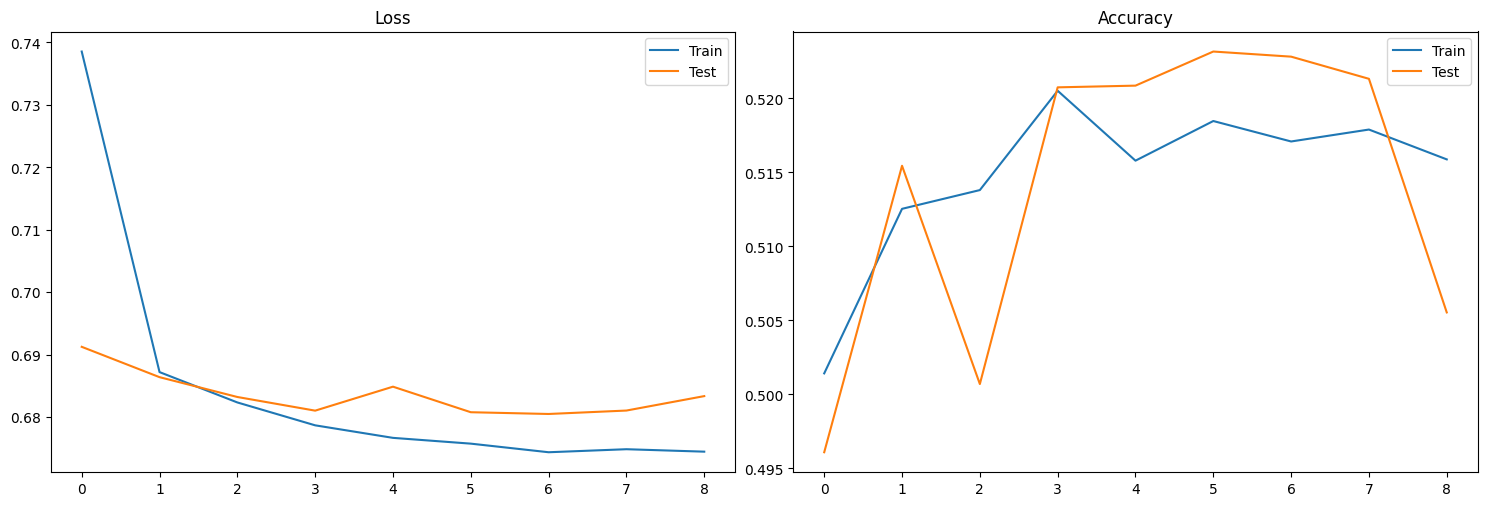

In [44]:
show_model_history(simple_rnn_history)

### 6.2.2 Bidirectional GRU

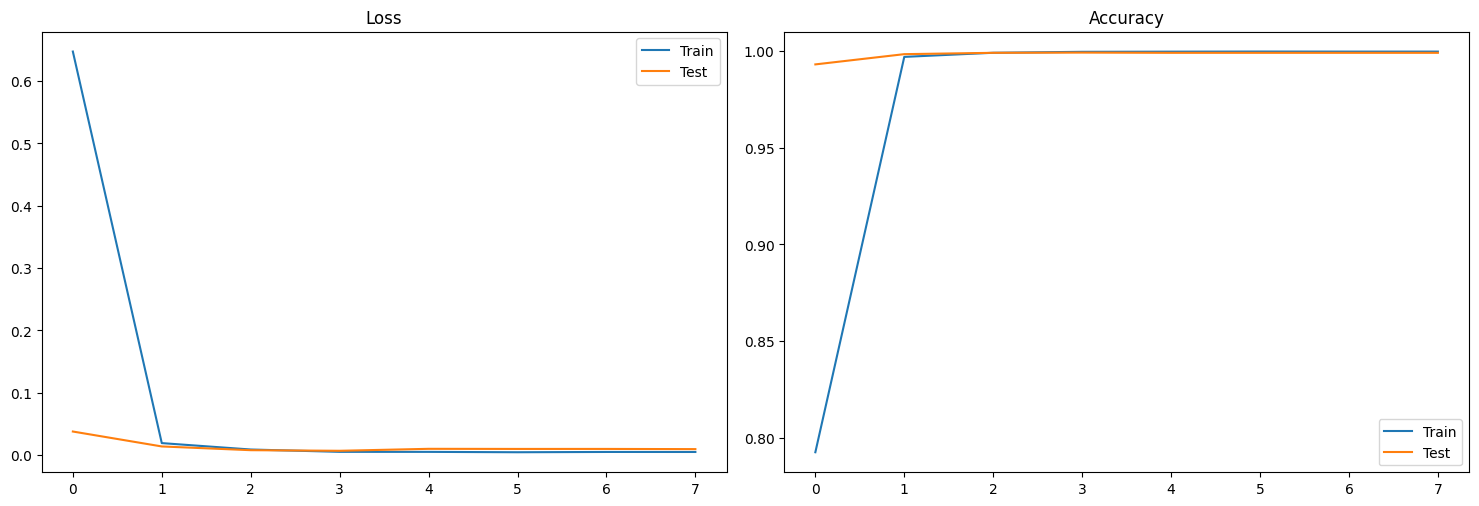

In [49]:
show_model_history(rnn_gru_bidirectional_history)

### 6.2.3 NeuralNet Binary Classifier

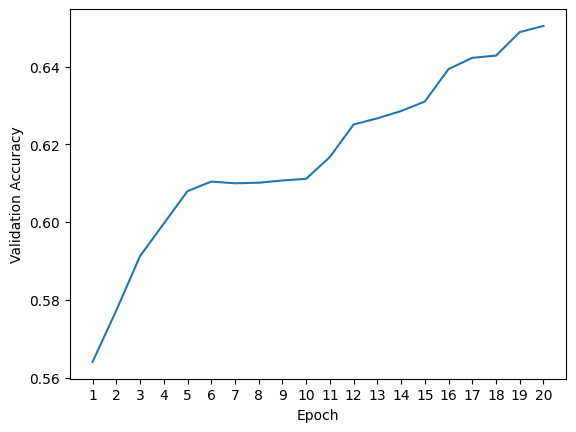

In [63]:
plt.plot(range(1,21), val_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.xticks(range(1,21))
plt.show()

#### 6.2.3.1 Increasing Maximum Epochs
I increased the maximum epochs for the NeuralNet Binary Classifier to 50.  The model shows convergence around epoch 42, leading me to believe that adding even more epochs would not significantly improve the validation accuracy of the model.

In [65]:
MAX_EPOCHS = 50

nnbc_model_50 = NeuralNetBinaryClassifier(
    NewsClassifier,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    max_epochs=MAX_EPOCHS,
    batch_size=batch_size
)

start_time = time.time()

nnbc_history = nnbc_model_50.fit(x_tr, y_tr)

end_time = time.time()

elapsed_time = end_time - start_time

#Grabbing the validation accuracy out of this model was not as nice as the prior models
val_acc_50 = []
for i in range(MAX_EPOCHS):
    acc = nnbc_history.history[i]['valid_acc']
    val_acc_50.append(acc)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       98.2009       0.5721       55.4114  0.2790
      2       37.9485       0.5807       29.5597  0.2460
      3       18.5145       0.5904       16.5564  0.2509
      4        9.3760       0.5898        9.2968  0.2480
      5        4.6548       0.5963        4.8667  0.2492
      6        2.2848       0.6067        2.7210  0.2538
      7        1.3410       0.6182        1.9438  0.2535
      8        0.9670       0.6267        1.5384  0.2545
      9        0.7870       0.6310        1.3931  0.2521
     10        0.6953       0.6395        1.2948  0.2464
     11        0.6347       0.6447        1.2439  0.2439
     12        0.5965       0.6478        1.2073  0.2491
     13        0.5697       0.6513        1.2009  0.2404
     14        0.5500       0.6513        1.1881  0.2440
     15        0.5327       0.6548        1.1833  0.2442
     16        0.5167       0.6

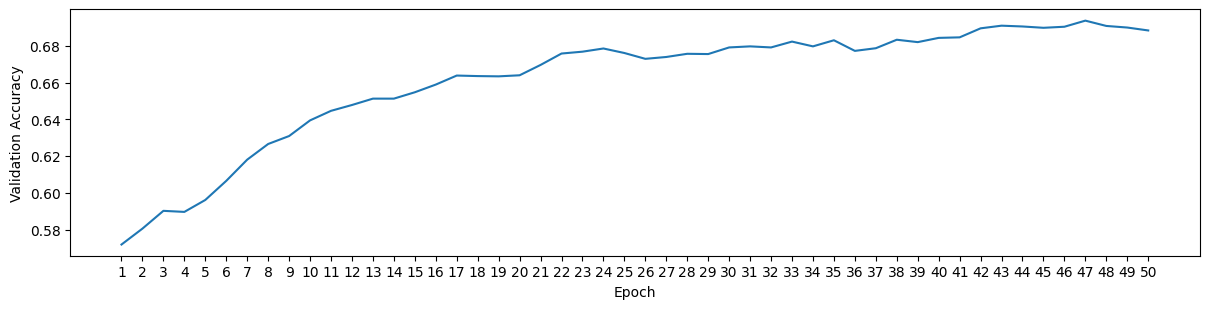

In [114]:
plt.figure(figsize=(12,3))
plt.plot(range(1,51), val_acc_50)
plt.tight_layout()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.xticks(range(1,51))
plt.show()

## 6.3 Confusion Matrix
I created confusion matrices for the models with the best validation accuracy (i.e., bidirectional GRU) and fastest training time (i.e., NeuralNet Binary Classifier).  Although the model results summary table above indicated that the bidirectional GRU had signficantly better accuracy, the confusion matrix shows how much better the bidirectional GRU was in both type I and type II errors compared to the NeuralNet Binary Classifier. 

### 6.3.1 Bidirectional GRU

In [103]:
y_p = rnn_gru_bidirectional.predict(x_test.values)
y_pred = (y_p > 0).astype('int32')

272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


<Axes: >

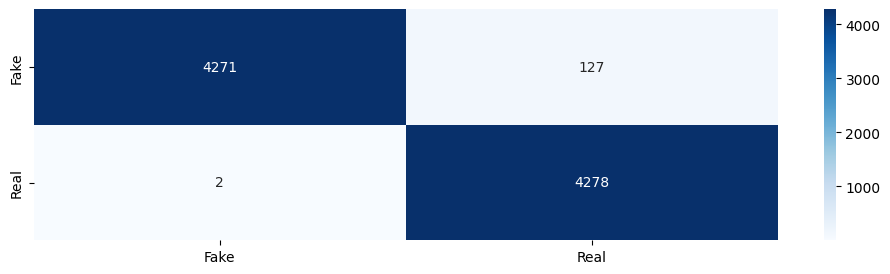

In [104]:
cm = confusion_matrix(y_test.values, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', yticklabels=['Fake', 'Real'], xticklabels=['Fake', 'Real'])

### 6.3.2 NeuralNet Binary Classifier

In [51]:
y_pred = nnbc_model.predict(x_te)

<Axes: >

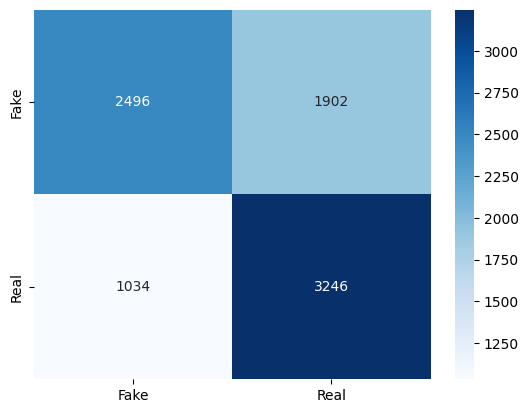

In [55]:
cm = confusion_matrix(y_te, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', yticklabels=['Fake', 'Real'], xticklabels=['Fake', 'Real'])

# 7. Discussion and Conclusion

## 7.1 Learnings and Takeaways
In the end, the bidirectional GRU was the best model I created.  Although the training time was lengthy compared to some of the other models, the predictive power was unmatched.

I was surprised to see the vast difference in training time and validation accuracy across the various models I built.  Neural Networks seem to be more of an art than a science when determining the number of layers, architecture, and hyperparameter values.  Although there are some ways to inject the scientific method, such as automating hyperparameter tuning, there still appears to be a fair amount of trial and error to arrive at the final model.  

## 7.2 Things that Did Not Go as Planned
I attempted to use KTrain (https://pypi.org/project/ktrain/), which provides a wrapper around TensorFlow Keras and provides some pretrained NLP models.  However, KTrain does not support Keras 3.  After trying to downgrade TensorFlow and Keras to a compatible version, I could not get the environment to run without errors.  Therefore, I switched approaches and implemented the NeuralNet Binary Classifier from skorch.

As an aside to my peer reviewers, the NLP courses in this MSDS program give a nice opportunity to work with KTrain.  If you haven't taken those classes, I highly recommend them.

## 7.3 Ways to Improve
As mentioned above, I saw models with great accuracy but slow performance and models with poor accuracy but great performance.  I would like to dig further into why the NeuralNet Binary Classifier was so much faster.  From some brief research, skorch leverages PyTorch's high performance with deep learning operations.  However, I question if there was an error in my model given the significant difference in training time compared to the TensorFlow Keras models.  If I implemented the NeuralNet Binary Classifier correctly and it is truly that much faster, I could apply that learning to improve the training performance of the other models.  If there was an error in my implementation, I could fix the NeuralNet Binary Classifier to improve its predictive power.

# 8. References
1. https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/02/ISOT_Fake_News_Dataset_ReadMe.pdf
2. https://medium.com/@sid321axn/fake-news-detection-using-nlp-and-machine-learning-in-python-wisdom-ml-6f548b0691a7
3. https://skorch.readthedocs.io/en/stable/classifier.html
